# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

In [1]:
import pandas as pd
import glob
import email
import re
import nltk
import sklearn

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
def _remove_html_tags(text):
    return re.sub("<[^>]*>", "", text)

def _remove_emails(text):
    return re.sub("[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.].+", "", text)

def _lowercase_all(text):
    return text.lower()

def _remove_special_characters(text):
    return re.sub("[^A-Za-z0-9]+", " ", text)

def _remove_numbers(text):
    return re.sub("[0-9]+", "", text)

def _remove_single_letters(text):
    words_list = text.split()
    clean_text_words = []
    for word in words_list:
        if len(word) > 1:
            clean_text_words.append(word)
    return " ".join(clean_text_words)

def _lemmatization_of_words(text):    
    from nltk.stem.porter import PorterStemmer
    clean_text_words = []
    porter = PorterStemmer()
    sentence_words = nltk.word_tokenize(text)
    
    for word in sentence_words:
        clean_text_words.append(porter.stem(word))
    
    return " ".join(clean_text_words)

def _remove_stop_words(text):
    from nltk.corpus import stopwords
    
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    words_filtered = []

    for word in words:
        if word not in stop_words:
            words_filtered.append(word)
    
    return " ".join(words_filtered)

def _remove_nonsense_words(text):
    from nltk.corpus import words
    words = set(words.words())
    
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w in words)

def _remove_websites(text):
    regex = r'\b((?:[a-z][\w-]+:(?:\/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}\/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’]))'
    return re.sub(regex, "", text)

In [4]:
def _clean_body_message(body):
    message_without_html_tags = _remove_html_tags(body)

    message_without_websites = _remove_websites(message_without_html_tags)

    message_without_emails = _remove_emails(message_without_websites)

    message_lowercase = _lowercase_all(message_without_emails)

    message_without_numbers = _remove_numbers(message_lowercase)

    message_without_special_characters = _remove_special_characters(message_without_numbers)
    
    message_without_single_letters = _remove_single_letters(message_without_special_characters)
    
    message_without_stop_words = _remove_stop_words(message_without_single_letters)
    
    message_with_correct_words = _remove_nonsense_words(message_without_stop_words)
    
    clean_message = _lemmatization_of_words(message_with_correct_words)
    
    return clean_message

In [5]:
def _get_body_message(all_message):
    b = email.message_from_string(all_message)
    body = ""

    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload()  # decode
                break
    else:
        body = b.get_payload()
    
    return _clean_body_message(body)

In [6]:
def preprocess_files(files):
    mail_body_messages = []
    for filename in files:
        with open(filename, 'rt', encoding = "ISO-8859-1") as f:
            body_message = _get_body_message(f.read())
            if len(body_message) > 0: 
                mail_body_messages.append(body_message)
    return mail_body_messages

# Procesamiento de datos

In [7]:
first_easy_ham_files = glob.glob("datos/spam-filter/easy_ham/0*")
second_easy_ham_files = glob.glob("datos/spam-filter/easy_ham_2/0*")
first_hard_ham_files = glob.glob("datos/spam-filter/hard_ham/0*")
second_hard_ham_files = glob.glob("datos/spam-filter/hard_ham_2/0*")
first_spam_files = glob.glob("datos/spam-filter/spam/0*")
second_spam_files = glob.glob("datos/spam-filter/spam_2/0*")

first_easy_ham_messages = preprocess_files(first_easy_ham_files)
second_easy_ham_messages = preprocess_files(second_easy_ham_files)
first_hard_ham_messages = preprocess_files(first_hard_ham_files)
second_hard_ham_messages = preprocess_files(second_hard_ham_files)
first_spam_messages = preprocess_files(first_spam_files)
second_spam_messages = preprocess_files(second_spam_files)

Veremos si la limpieza de los mensajes fue correcta

In [8]:
first_easy_ham_messages[:3]

['date wed messag id reproduc error repeat like everi time without fail log pick happen pick pick list subject sequenc pick list subject sequenc hit mark syntax error express note run pick command hand delta pick list subject sequenc hit hit come obvious version delta pick version pick mu sun mar relev part profil delta pick list sinc pick command work sequenc actual one explicit command line search one come profil get still version code form day ago abl reach repositori today local rout issu think list',
 'martin post sculptor behind plan limeston mount east far mount monast commun ideal patriot sculptur well granit high wide museum car park admir mountain limeston granit limeston weather pretti fast yahoo sponsor free join group send use yahoo subject',
 'man explos august secur unidentifi man said arm blow truck front russia feder secur headquart televis automat rifl man carri man got truck taken custodi said immedi avail man high govern tass news said radio talk presid polic secur 

Implementacion de Bag of words

In [9]:
def get_bag_of_words_dataset(files, is_spam_files):    
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    bag_of_words = vectorizer.fit_transform(files).todense()
    dataframe = pd.DataFrame(bag_of_words, columns=vectorizer.get_feature_names())
    
    if is_spam_files:
        dataframe['spam'] = 1
    else:
        dataframe['spam'] = 0
        
    return dataframe

In [10]:

first_easy_ham_dataset = get_bag_of_words_dataset(first_easy_ham_messages, False)
second_easy_ham_dataset = get_bag_of_words_dataset(second_easy_ham_messages, False)
first_hard_ham_dataset = get_bag_of_words_dataset(first_hard_ham_messages, False)
second_hard_ham_dataset = get_bag_of_words_dataset(second_hard_ham_messages, False)
first_spam_dataset = get_bag_of_words_dataset(first_spam_messages, True)
second_spam_dataset = get_bag_of_words_dataset(second_spam_messages, True)

In [11]:
all_df= [first_easy_ham_dataset, second_easy_ham_dataset, first_hard_ham_dataset,
        second_hard_ham_dataset, first_spam_dataset, second_spam_dataset]
spam_df = pd.concat(all_df, axis=0, ignore_index=True)

Los datos como estan en este momento tienen algunas casillas con NaN's por lo que eliminaremos estos valores poniendolos en 0, por lo que ahora vamos a dividir los datos en 2. Uno para entrenar y otro para comprobar dicho entrenamiento

In [12]:
spam_df = spam_df.fillna(value=0)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(spam_df.drop('spam', axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
scaled_features = scaler.transform(spam_df.drop('spam',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=spam_df.columns.drop('spam'))

In [15]:
df_feat.shape

(6170, 12246)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, 
                                                    spam_df['spam'], test_size=0.30)

# Regresion logistica

Primero debes entrenar el modelo para que pueda hacer las predicciones

In [17]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
predictions = logmodel.predict(X_test)

Miramos que tambien quedo entrenado el modelo obteniendo 4 valores los cuales nos ayudaran a mirar esto, Falsos negativos, falsos positivos, verdaderos positivos y verdaderos negativos. Asi sabremos que tanto % de exito tuvo la prediccion

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.99      0.92      0.95      1292
          1       0.84      0.97      0.90       559

avg / total       0.94      0.94      0.94      1851



In [20]:
print(confusion_matrix(y_test, predictions))

[[1188  104]
 [  16  543]]


Los resultados obtenidos fueron:
    Falsos positivos: 116.
    Falsos negativos: 11.
    Verdaderos positivos: 1195.
    Verdaderos negativos: 529.
    Teniendo una precision del 93%

# Red Neuronal

Necesitamos una neurona para cada caracteristica de los datos (columnas de los datos), como vimos anteriormente son 12246 con el comando shape, por lo tanto usaremos un max de 6123 neuronas que es la mitad del numero total por temas de limites computacionales

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def print_history(fitted_model, units):
    plt.plot(fitted_model.history['acc'])
    plt.plot(fitted_model.history['val_acc'])
    plt.title('Precision del modelo con {} unidades'.format(units))
    plt.ylabel('Precisión')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
    plt.show()

In [23]:
import keras

num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

C:\Users\Usuario\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
from keras.layers import Dense 
from keras.models import Sequential

number_of_features = df_feat.shape[1]
quantity_of_units = [32, 630, 1024, 6123] 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


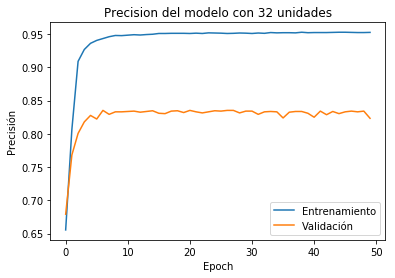

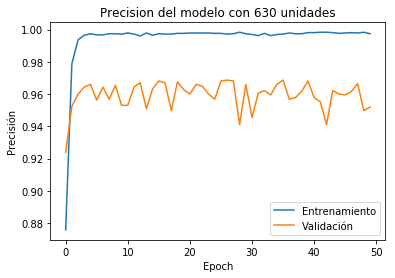

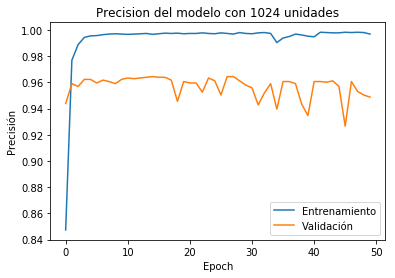

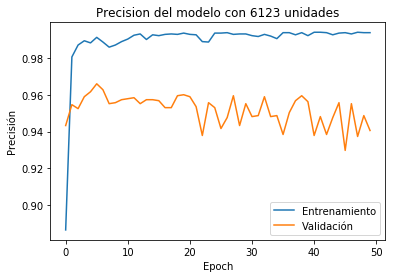

In [25]:
for units in quantity_of_units:
    model=Sequential()
    model.add(Dense(units, input_dim=number_of_features, activation='relu'))
    keras.layers.core.Dropout(rate=0.4)
    model.add(Dense(num_classes,input_dim=number_of_features,activation='softmax'))

    
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

    fit_history = model.fit(X_train,y_train,epochs=50,batch_size=128,verbose=0, validation_data=(X_test,y_test))
    print_history(fit_history, units) 

En este caso el mejor resultado fue con 630 neuronas, ya que las otras a medida que subia la cantidad de neuronas fue perdiendo la precision, 32 neuronas son pocas pero mas de 630 ocasiona perdidas en la precision.
Adicionalmente no baja de mas del 94% y tiene un promedio de 96% de precicion con 630 neuronas, es por esto que la red neuronal es mejor ya que la regresion logistica nos habia dado una precision del 93%. Teniendo las 2 una alta taza de exito